<a href="https://colab.research.google.com/github/Maupin1991/vgg_face_tensorflow/blob/master/VGG_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')
import os

In [0]:
names_fpath = '/gdrive/My Drive/colab_data/names.txt'


class NameLookup:
    def __init__(self):
        self._uid_to_name = {}
        self._cls_to_uid = {}

        self.path = names_fpath
        with open(self.path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                uid, name = line.split()
                self._uid_to_name[uid] = name
                self._cls_to_uid[uid] = uid

    def uid_to_name(self, uid):
        return self._uid_to_name[uid].replace('_', ' ')

    def cls_to_name(self, cls):
        # todo test this
        return self._uid_to_name[self._cls_to_uid[cls]]


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import io

model_path = '/gdrive/My Drive/colab_data/vggface16.tfmodel'


class VGGFace():

    def __init__(self):
        self._name_lookup = NameLookup()
        self._graph = tf.Graph()
        self._model_path = model_path

        with self._graph.as_default():
            with tf.gfile.FastGFile(self._model_path, 'rb') as f:
                graph_def = tf.GraphDef()
                graph_def.ParseFromString(f.read())
                tf.import_graph_def(graph_def,
                                    input_map={
                                        "images": tf.placeholder(
                                            tf.float32,
                                            shape=(None, 224, 224, 3),
                                            name='import/images')})

            self._y_pred = self._graph.get_tensor_by_name('import/prob:0')
            self._y_logits = self._graph.get_tensor_by_name('import/fc8/BiasAdd:0')
            self._resized_image = self._graph.get_tensor_by_name('import/images:0')

            self._session = tf.Session(graph=self._graph)

    def close(self):
        self._session.close()
        
    def _create_feed_dict(self, image=None, image_path=None, image_url=None):
        
        if image_path is not None:
            image = plt.imread(image_path)
        
        elif image_url is not None:
            image = io.imread(image_url)
        
        if image is not None:
            image = resize(image, (224, 224))
            image = image.reshape((1, 224, 224, 3))
            
            feed_dict = {"import/images:0": image}
        else:
            raise ValueError("Either image, image_path or image_url " +
                             "must be set.")
        return feed_dict
    
    def classify(self, **kwargs):
        feed_dict = self._create_feed_dict(**kwargs)
        pred = self._session.run(self._y_pred, feed_dict = feed_dict)
        pred = np.squeeze(pred)
        return pred
    
    def print_scores(self, pred, k=10):
        idx = pred.argsort()
        top_k = idx[-k:]
        for clss in reversed(top_k):
            name = self._name_lookup.cls_to_name(cls=str(clss))
            score = pred[clss]
            print("{0:>6.2%} : {1}".format(score, name))
        

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


97.23% : Steve_Jobs
 0.10% : Ben_Miller
 0.08% : Adam_Brody


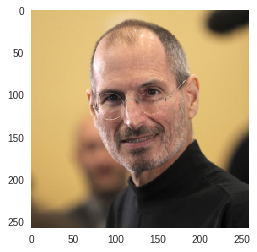

In [41]:
image_url = "https://argomenti.ilsole24ore.com/Immagini/Editrice/ILSOLE24ORE/ARGOMENTI/Online/Persone/Immagini/Imprenditori/steve-jobs.jpg" #@param {type:"string"}

model = VGGFace()
pred = model.classify(image_url=image_url)
model.print_scores(pred, k=3)
model.close()

%matplotlib inline
plt.imshow(io.imread(image_url))
plt.grid('off')
plt.show()

[Easter Egg](http://www.wikicu.com/Adam_Goldberg)

Try This image_url: 'https://www.thehindu.com/news/international/f4t4xz/article24464654.ece/alternates/FREE_300/20TH-ZUCKERBERG'